In [1]:
using HDF5, JLD

In [2]:
# add additional processes to serve as workers 
n_procs = 6
addprocs(n_procs);  

In [3]:
# add present working directory to path from which to load modules
push!(LOAD_PATH, ".") 

# load module DynamicProgramming on each of the processes 
using DynamicProgramming
using Interpolations

In [4]:
# nominal parameter value 
@everywhere T1 = 0.680 # seconds in white matter 
@everywhere T2 = 0.090 # seconds in white matter 
@everywhere dT = 0.2   # seconds between acquisitions 
@everywhere sigma = 0.1  # noise strength 
@everywhere theta0 = [exp(-dT/T1); exp(-dT/T2)]

# time horizon 
@everywhere N = 30

# state dimension 
@everywhere n = 6

# initial state
@everywhere x0 = [0.; 0.; 1.; 0; 0; 0]

# define rotation matrices 
@everywhere function Rx(alpha::Float64)
    return [1     0           0     ;
            0 cos(alpha) -sin(alpha);
            0 sin(alpha)  cos(alpha)]
end
@everywhere function Ry(alpha::Float64)
    return [cos(alpha) 0 -sin(alpha);
                0      1      0     ;
            sin(alpha) 0  cos(alpha)]
end
@everywhere function Rz(alpha::Float64)
    return [cos(alpha) -sin(alpha) 0;
            sin(alpha)  cos(alpha) 0;
                0           0      1]
end

# dynamics 
@everywhere function f(t::Int64, x::Array{Float64, 1}, u::Array{Float64, 1}, theta::Array{Float64, 1})
    x_state = x[1:3]
    x_sensitivity = x[4:6]
    U = Rz(u[1])*Ry(u[2])*Rx(u[3])
    D = [theta[2], theta[2], theta[1]]
    x_state_plus = U*(D.*x_state) + [0; 0; 1-theta[1]]
    x_sensitivity_plus = U*(D.*x_sensitivity) + U*([0; 0; 1].*x_state) + [0; 0; -1]
    return [x_state_plus; x_sensitivity_plus]
end

# test dynamics 
f(1, x0, [0.; 0.; 0.], theta0)

# reward function 
@everywhere function g(k::Int64, x::Array{Float64, 1}, u::Array{Float64, 1}, theta::Array{Float64, 1})
    return x[4]^2 + x[5]^2 
end

# terminal reward 
@everywhere function g_terminal(x::Array{Float64, 1})
    return x[4]^2 + x[5]^2 
end

# test reward function 
g(0, x0, [0.; 0.; 0.], theta0)

# define state grid 
@everywhere nx1 = 6 # number of grid points in each dimension  
@everywhere nx2 = 6
@everywhere nx3 = 6
@everywhere nx4 = 7
@everywhere nx5 = 7
@everywhere nx6 = 7
@everywhere xgrid = (
                     linspace(-1., 1., nx1), 
                     linspace(-1., 1., nx2), 
                     linspace(-1., 1., nx3), 
                     linspace(-50., 50., nx4), 
                     linspace(-50., 50., nx5), 
                     linspace(-100., 100., nx6)
                    ) 

# define input grid
# make nu's even so that there is a grid knot at zero
@everywhere nu1 = 1
@everywhere nu2 = 16
@everywhere nu3 = 8
@everywhere ugrid = (
                     linspace(0, 0, nu1), 
                     linspace(-pi, pi-2*pi/nu2, nu2), 
                     linspace(0, pi-pi/nu3, nu3)
                    ) 

In [5]:
# define invariants 

@everywhere function rho(x::Array{Float64, 1})
    r = sqrt(x[1]*x[1] + x[2]*x[2])
    return [r;
            x[3];
            1/r*(x[2]*x[4] - x[1]*x[5]);
            1/r*(x[1]*x[4] + x[2]*x[5]);
            x[6]]
end

@everywhere function rho_bar_inverse(x_bar::Array{Float64, 1})
    return [0; x_bar]
end

In [6]:
# @everywhere nx1_reduced = 6
# @everywhere nx2_reduced = 15
# @everywhere nx3_reduced = 20
# @everywhere nx4_reduced = 20
# @everywhere nx5_reduced = 20

@everywhere nx1_reduced = 6
@everywhere nx2_reduced = 10
@everywhere nx3_reduced = 15
@everywhere nx4_reduced = 15
@everywhere nx5_reduced = 15


@everywhere xgrid_reduced = (
                     linspace(0.01, 0.6, nx1_reduced), 
                     linspace(1-2*theta0[1], 1., nx2_reduced), 
                     linspace(-5., 5., nx3_reduced), 
                     linspace(-5., 5., nx4_reduced), 
                     linspace(-5., 5., nx5_reduced)
                    ) 

@time J = dp_reduced(f, g, g_terminal, rho, rho_bar_inverse, ugrid, xgrid_reduced, theta0, N);

====== Constructing array J ======
J is size (6,10,15,15,15) by 30
====== Array J constructed  ======
Step k = 30
Step k = 29
Step k = 28
Step k = 27
Step k = 26
Step k = 25
Step k = 24
Step k = 23
Step k = 22
Step k = 21
Step k = 20
Step k = 19
Step k = 18
Step k = 17
Step k = 16
Step k = 15
Step k = 14
Step k = 13
Step k = 12
Step k = 11
Step k = 10
Step k = 9
Step k = 8
Step k = 7
Step k = 6
Step k = 5
Step k = 4
Step k = 3
Step k = 2
Step k = 1
12694.522147 seconds (73.41 M allocations: 2.173 GB, 0.00% gc time)


In [7]:
J[:, :, 1, 1, 1]

6×10 Array{Float64,2}:
 84.6414  82.994   81.4187  -Inf       …  76.4151  75.3281  74.1721  72.3506
 84.7116  83.0672  81.4282    80.0245     76.3935  75.3005  74.1674  72.3561
 84.7455  83.058   81.4601    80.0415     76.3682  75.2714  74.0115  72.3596
 84.7408  83.0435  81.4919    80.041      76.352   75.2659  74.0099  72.3611
 84.6956  83.117   81.4274    80.0398     76.3449  75.2501  74.0069  72.3608
 84.7806  83.1318  81.4336    80.0901  …  76.3455  75.2518  73.9198  72.2263

In [8]:
# save value function computed at grid points 
save("J_MR_fingerprinting.jld", "data", J)

In [9]:
# reload value function 
# J = load("J_MR_fingerprinting.jld)["data"]; 

In [10]:
# define a finer input grid for policy rollout 
@everywhere nu1 = 32
@everywhere nu2 = 32
@everywhere nu3 = 16
@everywhere ugrid = (
                     linspace(0, 0, 1), 
                     linspace(-pi, pi-2*pi/nu2, nu2), 
                     linspace(0, pi-pi/nu3, nu3)
                    ) 


# compute optimal trajectory from initial condition x0 
x0 = [0.; 0.; 1.; 0.; 0.; 0.]
x_opt, u_opt = dp_rollout_reduced(J, x0, f, g, rho, ugrid, xgrid_reduced, theta0, N); 

In [11]:
using Colors 
using Gadfly

berkeley_blue = RGB((1/256*[ 45.,  99., 127.])...)
berkeley_gold = RGB((1/256*[224., 158.,  25.])...); 
gray          = RGB((1/256*[200., 200., 200.])...); 

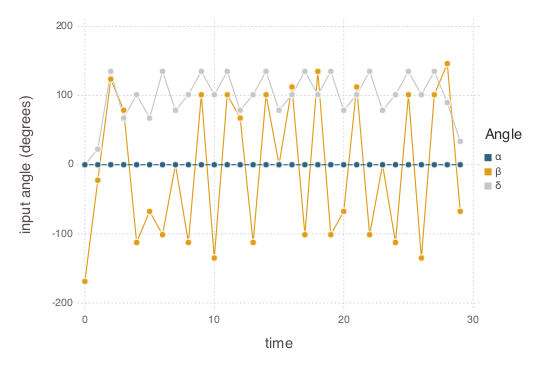

In [12]:
# plot optimal input 

p = plot(layer(x=0:N-1, y=180/pi*u_opt[1, :], Geom.point, Geom.line, Theme(default_color=berkeley_blue)), 
        layer(x=0:N-1, y=180/pi*u_opt[2, :], Geom.point, Geom.line, Theme(default_color=berkeley_gold)), 
        layer(x=0:N-1, y=180/pi*u_opt[3, :], Geom.point, Geom.line, Theme(default_color=gray)), 
        Guide.XLabel("time"), 
        Guide.YLabel("input angle (degrees)"),
Guide.manual_color_key("Angle", ["α", "β", "δ"], [berkeley_blue, berkeley_gold, gray])
)
draw(SVG("MRI_full_input.svg", 15cm, 10cm), p)
p

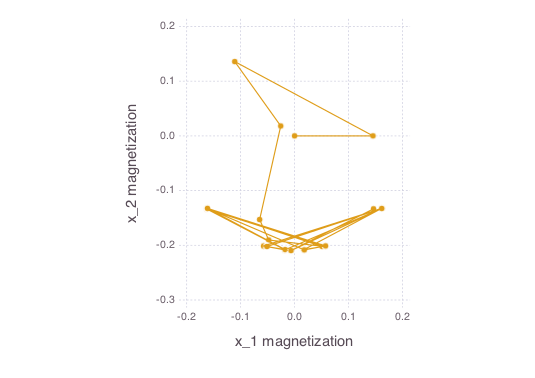

In [13]:
# plot optimal trajectory in transverse plane 

p = plot(x=x_opt[1, :], y=x_opt[2, :], 
        Guide.XLabel("x_1 magnetization"), 
        Guide.YLabel("x_2 magnetization"), 
        Geom.path, Geom.point, Coord.cartesian(fixed=true),
        Theme(default_color=berkeley_gold)
)
draw(SVG("MRI_full_trajectory_transverse_plane.svg", 10cm, 20cm), p)
p

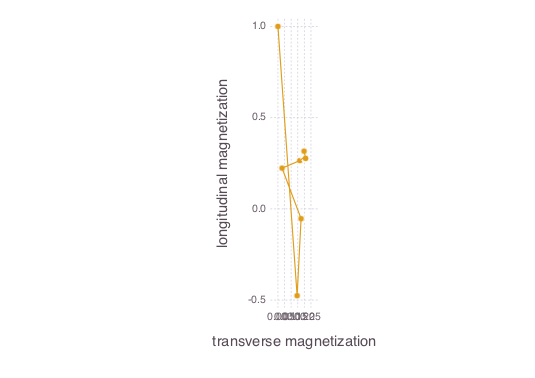

In [14]:
# plot optimal trajectory in transverse vs. longitudinal

p = plot(x=sqrt(x_opt[1, :].^2 + x_opt[2, :].^2), y=x_opt[3, :], 
        Guide.XLabel("transverse magnetization"), 
        Guide.YLabel("longitudinal magnetization"), 
        Geom.path, Geom.point, Coord.cartesian(fixed=true),
        Theme(default_color=berkeley_gold)
)
draw(SVG("MRI_full_trajectory_transverse_vs_longitudinal.svg", 10cm, 20cm), p)
p

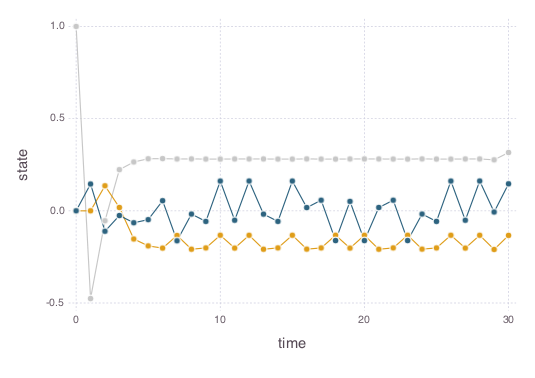

In [15]:
p = plot(layer(x=0:N, y=x_opt[1, :], Geom.point, Geom.line, Theme(default_color=berkeley_blue)), 
        layer(x=0:N, y=x_opt[2, :], Geom.point, Geom.line, Theme(default_color=berkeley_gold)), 
        layer(x=0:N, y=x_opt[3, :], Geom.point, Geom.line, Theme(default_color=gray)), 
        Guide.XLabel("time"), 
Guide.YLabel("state"),
# Guide.manual_color_key("Angle", ["α", "β", "δ"], [berkeley_blue, berkeley_gold, gray])
)

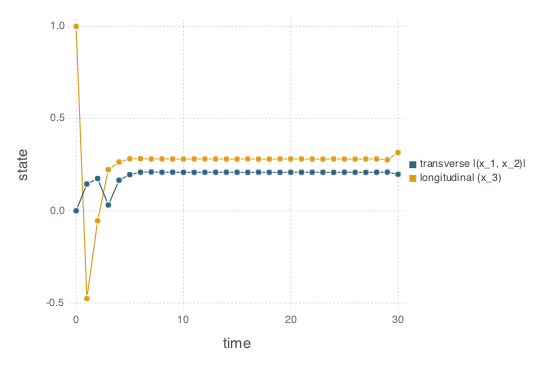

In [16]:
p = plot(layer(x=0:N, y=sqrt(x_opt[1, :].^2 + x_opt[2, :].^2), Geom.point, Geom.line, Theme(default_color=berkeley_blue)), 
        layer(x=0:N, y=x_opt[3, :], Geom.point, Geom.line, Theme(default_color=berkeley_gold)), 
        # layer(x=0:N, y=x_opt[6, :], Geom.point, Geom.line, Theme(default_color=gray)), 
        Guide.XLabel("time"), 
        Guide.YLabel("state"),
        Guide.manual_color_key("", ["transverse |(x_1, x_2)|", "longitudinal (x_3)"], [berkeley_blue, berkeley_gold])
)

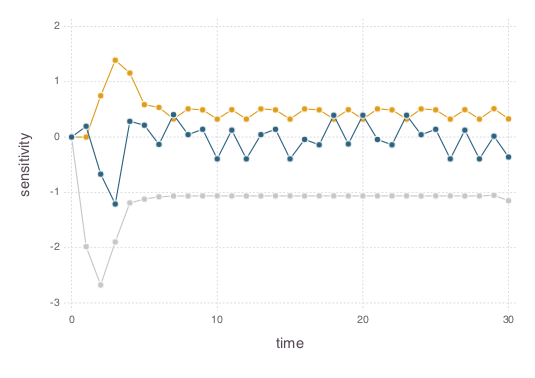

In [17]:
p = plot(layer(x=0:N, y=x_opt[4, :], Geom.point, Geom.line, Theme(default_color=berkeley_blue)), 
        layer(x=0:N, y=x_opt[5, :], Geom.point, Geom.line, Theme(default_color=berkeley_gold)), 
        layer(x=0:N, y=x_opt[6, :], Geom.point, Geom.line, Theme(default_color=gray)), 
        Guide.XLabel("time"), 
Guide.YLabel("sensitivity"),
# Guide.manual_color_key("Angle", ["α", "β", "δ"], [berkeley_blue, berkeley_gold, gray])
)

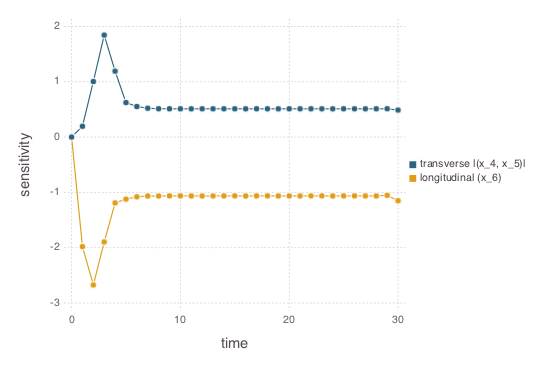

In [18]:
p = plot(layer(x=0:N, y=sqrt(x_opt[4, :].^2 + x_opt[5, :].^2), Geom.point, Geom.line, Theme(default_color=berkeley_blue)), 
        layer(x=0:N, y=x_opt[6, :], Geom.point, Geom.line, Theme(default_color=berkeley_gold)), 
        # layer(x=0:N, y=x_opt[6, :], Geom.point, Geom.line, Theme(default_color=gray)), 
        Guide.XLabel("time"), 
Guide.YLabel("sensitivity"),
Guide.manual_color_key("", ["transverse |(x_4, x_5)|", "longitudinal (x_6)"], [berkeley_blue, berkeley_gold])
)

In [19]:
Pkg.status()

12 required packages:
 - Cairo                         0.2.35
 - Compose                       0.4.4
 - Fontconfig                    0.1.1
 - GR                            0.19.0
 - Gadfly                        0.5.2
 - HDF5                          0.7.2
 - IJulia                        1.4.1
 - Interpolations                0.3.6
 - JLD                           0.6.9
 - Plots                         0.10.3
 - PyPlot                        2.2.4
 - StatPlots                     0.2.1
55 additional packages:
 - AxisAlgorithms                0.1.5
 - BinDeps                       0.4.5
 - Blosc                         0.1.7
 - Calculus                      0.2.0
 - ColorTypes                    0.2.12
 - Colors                        0.6.9
 - Compat                        0.13.0
 - Conda                         0.4.0
 - Contour                       0.2.0
 - DataArrays                    0.3.11
 - DataFrames                    0.8.5
 - DataStructures                0.5.2
 - DiffBase 